In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
df1 = pd.read_csv("data.csv",encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [4]:
df=df1.sample(frac=0.1, replace=False, random_state=1)

In [5]:
print("Dataset size:", len(df))

Dataset size: 160000


In [6]:
df.head(5)

,target,ids,date,flag,user,text
514293,0,2190584004,Tue Jun 16 03:08:48 PDT 2009,NO_QUERY,Vicki_Gee,i miss nikki nu nu already shes always there ...
142282,0,1881451988,Fri May 22 04:42:15 PDT 2009,NO_QUERY,PatCashin,So I had a dream last night. I remember a sig...
403727,0,2058252964,Sat Jun 06 14:34:17 PDT 2009,NO_QUERY,deelectable,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,0,2237307600,Fri Jun 19 05:34:22 PDT 2009,NO_QUERY,justinekepa,it is raining again
610789,0,2224301193,Thu Jun 18 09:20:06 PDT 2009,NO_QUERY,cmatt007,@MissKeriBaby wish I was in LA right now


In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
#decode_map = {"NEGATIVE":0,"NEUTRAL":2,"POSITIVE":4 }
def decode_sentiment(label):
#    return int(decode_map[label])
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 56.3 ms, sys: 3.21 ms, total: 59.5 ms
Wall time: 59.1 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

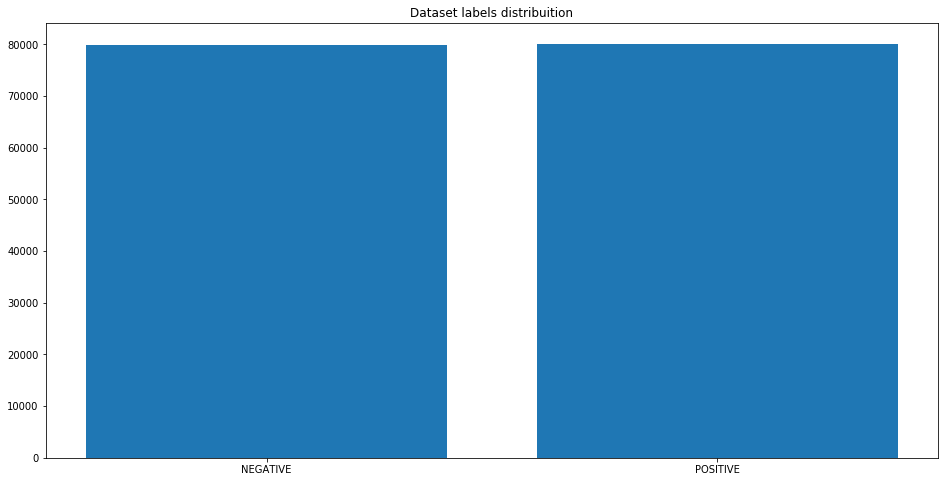

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 4.55 s, sys: 34.6 ms, total: 4.59 s
Wall time: 4.65 s


In [13]:
#Split train and test
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 128000
TEST size: 32000


In [14]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 205 ms, sys: 20.6 ms, total: 225 ms
Wall time: 227 ms


In [15]:
#word2vec
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-04-14 12:36:20,873 : INFO : collecting all words and their counts
2020-04-14 12:36:20,876 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-14 12:36:20,895 : INFO : PROGRESS: at sentence #10000, processed 72324 words, keeping 13838 word types
2020-04-14 12:36:20,917 : INFO : PROGRESS: at sentence #20000, processed 143756 words, keeping 21288 word types
2020-04-14 12:36:20,940 : INFO : PROGRESS: at sentence #30000, processed 216337 words, keeping 27504 word types
2020-04-14 12:36:20,967 : INFO : PROGRESS: at sentence #40000, processed 287880 words, keeping 32902 word types
2020-04-14 12:36:21,010 : INFO : PROGRESS: at sentence #50000, processed 360142 words, keeping 37627 word types
2020-04-14 12:36:21,038 : INFO : PROGRESS: at sentence #60000, processed 431661 words, keeping 42196 word types
2020-04-14 12:36:21,059 : INFO : PROGRESS: at sentence #70000, processed 503247 words, keeping 46453 word types
2020-04-14 12:36:21,083 : INFO : PROGRESS: at s

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 7589


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-04-14 12:37:26,176 : INFO : training model with 8 workers on 7589 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-04-14 12:37:26,921 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-14 12:37:26,945 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-14 12:37:26,948 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-14 12:37:26,979 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-14 12:37:26,983 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-14 12:37:26,996 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-14 12:37:27,007 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-14 12:37:27,025 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-14 12:37:27,026 : INFO : EPOCH - 1 : training on 920690 raw words (751186 effective words) took 0.8s, 899811 effect

2020-04-14 12:37:34,995 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-14 12:37:35,004 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-14 12:37:35,005 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-14 12:37:35,010 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-14 12:37:35,018 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-14 12:37:35,022 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-14 12:37:35,022 : INFO : EPOCH - 10 : training on 920690 raw words (751148 effective words) took 0.8s, 947613 effective words/s
2020-04-14 12:37:35,805 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-14 12:37:35,815 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-14 12:37:35,831 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-14 12:37:35,838 : INFO : worker threa

2020-04-14 12:37:42,628 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-14 12:37:42,629 : INFO : EPOCH - 19 : training on 920690 raw words (750880 effective words) took 0.9s, 870090 effective words/s
2020-04-14 12:37:43,467 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-14 12:37:43,487 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-14 12:37:43,493 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-14 12:37:43,498 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-14 12:37:43,506 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-14 12:37:43,511 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-14 12:37:43,512 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-14 12:37:43,514 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-14 12:37:43,515 : INFO : EPOCH - 20 :

2020-04-14 12:37:52,067 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-14 12:37:52,072 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-14 12:37:52,075 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-14 12:37:52,089 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-14 12:37:52,091 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-14 12:37:52,099 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-14 12:37:52,107 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-14 12:37:52,116 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-14 12:37:52,117 : INFO : EPOCH - 29 : training on 920690 raw words (751319 effective words) took 0.9s, 861776 effective words/s
2020-04-14 12:37:52,928 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-14 12:37:52,935 : INFO : worker threa

CPU times: user 1min 19s, sys: 874 ms, total: 1min 20s
Wall time: 28.5 s


(24034123, 29462080)

In [19]:
w2v_model.most_similar("love")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-04-14 12:37:57,720 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.39118558168411255),
 ('adore', 0.3636872172355652),
 ('miley', 0.34250548481941223),
 ('bless', 0.3358275890350342),
 ('amazingg', 0.33045339584350586),
 ('ilove', 0.3235648572444916),
 ('jonasbrothers', 0.3234638571739197),
 ('lovee', 0.32338404655456543),
 ('lols', 0.3222987651824951),
 ('lovato', 0.315848708152771)]

### tokenize_texts

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 67616
CPU times: user 1.99 s, sys: 31.5 ms, total: 2.03 s
Wall time: 2.09 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 2.53 s, sys: 49.5 ms, total: 2.58 s
Wall time: 2.62 s


In [22]:
#label_encoder
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (128000, 1)
y_test (32000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (128000, 300)
y_train (128000, 1)

x_test (32000, 300)
y_test (32000, 1)


In [25]:
y_train[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1]])

In [26]:
#embedding layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(67616, 300)


In [27]:
embedding_layer = Embedding(vocab_size, 
                            W2V_SIZE, weights=[embedding_matrix], 
                            input_length=SEQUENCE_LENGTH, trainable=False)

In [28]:
#build model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          20284800  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 20,445,301
Trainable params: 160,501
Non-trainable params: 20,284,800
_________________________________________________________________


In [29]:
#compile model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
#callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 115200 samples, validate on 12800 samples
Epoch 1/8
114688/115200 [============================>.] - ETA: 6s - loss: 0.5692 - accuracy: 0.6996 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-04-14 13:05:10,529 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


115200/115200 [==============================] - 1588s 14ms/sample - loss: 0.5690 - accuracy: 0.6998 - val_loss: 0.5189 - val_accuracy: 0.7438
Epoch 2/8
114688/115200 [============================>.] - ETA: 7s - loss: 0.5338 - accuracy: 0.7293 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-04-14 13:33:04,227 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


115200/115200 [==============================] - 1674s 15ms/sample - loss: 0.5337 - accuracy: 0.7294 - val_loss: 0.5086 - val_accuracy: 0.7516
Epoch 3/8
114688/115200 [============================>.] - ETA: 6s - loss: 0.5217 - accuracy: 0.7380 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-04-14 13:57:23,998 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


115200/115200 [==============================] - 1460s 13ms/sample - loss: 0.5216 - accuracy: 0.7381 - val_loss: 0.5013 - val_accuracy: 0.7553
Epoch 4/8
114688/115200 [============================>.] - ETA: 6s - loss: 0.5121 - accuracy: 0.7444 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-04-14 14:24:17,304 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


115200/115200 [==============================] - 1613s 14ms/sample - loss: 0.5123 - accuracy: 0.7443 - val_loss: 0.5003 - val_accuracy: 0.7570
Epoch 5/8
114688/115200 [============================>.] - ETA: 6s - loss: 0.5374 - accuracy: 0.7254 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-04-14 14:51:18,005 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


115200/115200 [==============================] - 1621s 14ms/sample - loss: 0.5372 - accuracy: 0.7255 - val_loss: 0.5048 - val_accuracy: 0.7518
Epoch 6/8
114688/115200 [============================>.] - ETA: 7s - loss: 0.5149 - accuracy: 0.7438 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-04-14 15:19:56,279 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


115200/115200 [==============================] - 1718s 15ms/sample - loss: 0.5150 - accuracy: 0.7437 - val_loss: 0.4986 - val_accuracy: 0.7581
Epoch 7/8
114688/115200 [============================>.] - ETA: 7s - loss: 0.5077 - accuracy: 0.7481 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-04-14 15:48:56,539 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


115200/115200 [==============================] - 1740s 15ms/sample - loss: 0.5077 - accuracy: 0.7481 - val_loss: 0.4961 - val_accuracy: 0.7584
Epoch 8/8
114688/115200 [============================>.] - ETA: 7s - loss: 0.5028 - accuracy: 0.7507 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-04-14 16:16:08,921 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


115200/115200 [==============================] - 1632s 14ms/sample - loss: 0.5028 - accuracy: 0.7507 - val_loss: 0.4945 - val_accuracy: 0.7598
CPU times: user 11h 47min 50s, sys: 26min 8s, total: 12h 13min 59s
Wall time: 3h 37min 26s


### Evaluate

In [34]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

32000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


ACCURACY: 0.76315624
LOSS: 0.4917167372703552
CPU times: user 6min 50s, sys: 21.1 s, total: 7min 11s
Wall time: 2min 6s


In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

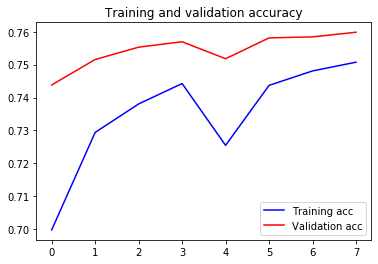

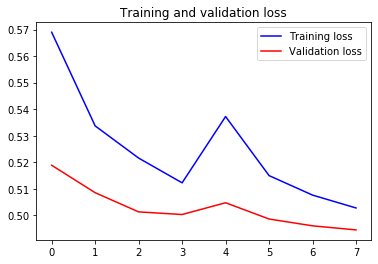

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [39]:
#predict
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [40]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9496554136276245,
 'elapsed_time': 1.4283201694488525}

In [41]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.0061029102653265,
 'elapsed_time': 0.16233205795288086}

In [42]:
predict("i don't know what i'm doing")

{'label': 'NEUTRAL',
 'score': 0.5465822815895081,
 'elapsed_time': 0.15106582641601562}

### confusion matrix

In [44]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

32000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

CPU times: user 5min 50s, sys: 58.7 s, total: 6min 49s
Wall time: 2min 31s


In [45]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

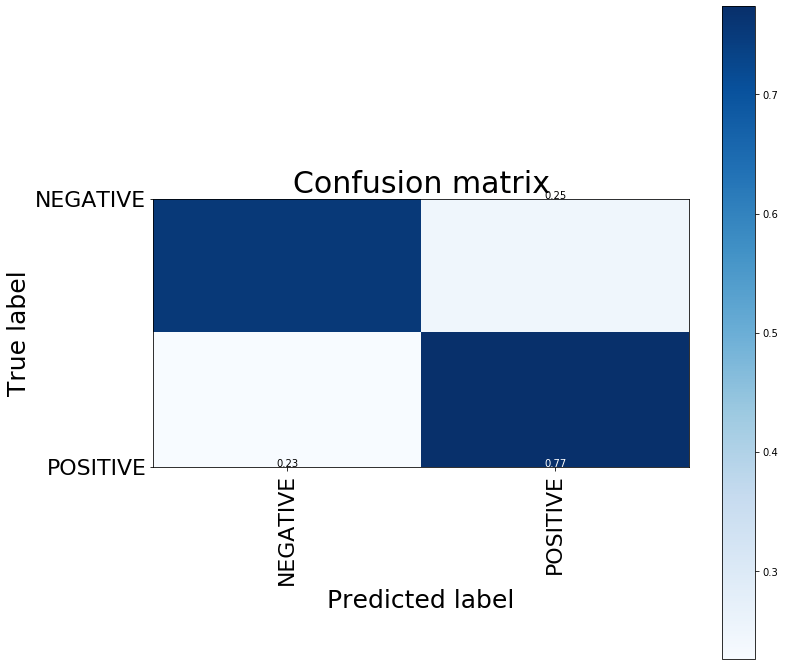

CPU times: user 454 ms, sys: 94.8 ms, total: 549 ms
Wall time: 513 ms


In [46]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [47]:
#classification report
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.75      0.76     16103
    POSITIVE       0.76      0.77      0.76     15897

    accuracy                           0.76     32000
   macro avg       0.76      0.76      0.76     32000
weighted avg       0.76      0.76      0.76     32000



In [48]:
#accuracy score
accuracy_score(y_test_1d, y_pred_1d)

0.76315625

In [49]:
#save model
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-04-14 17:29:19,590 : INFO : saving Word2Vec object under model.w2v, separately None
2020-04-14 17:29:19,597 : INFO : not storing attribute vectors_norm
2020-04-14 17:29:19,599 : INFO : not storing attribute cum_table
2020-04-14 17:29:20,076 : INFO : saved model.w2v
